<a href="https://colab.research.google.com/github/trong-khanh-1109/CS231.M13.KHCL/blob/main/Garbage_Classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown https://drive.google.com/uc?id=1C8BEEW_Lw4AUj4tHYNEjKaJIA6nnqYS3

Downloading...
From: https://drive.google.com/uc?id=1C8BEEW_Lw4AUj4tHYNEjKaJIA6nnqYS3
To: /content/Garbage classification 1.zip
100% 56.7M/56.7M [00:01<00:00, 37.4MB/s]


In [ ]:
!unzip '/content/Garbage classification 1.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Import library

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
FJoin = os.path.join
train_path = '/content/Garbage classification/train'
validation_path = '/content/Garbage classification/validation'
test_path = '/content/Garbage classification/test'
path = '/content/Garbage classification'

# Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        rotation_range = 20, # Dữ liệu được tạo ra sẽ được xoay ngẫu nhiên một góc trong phạm vi +rotation_rangeđến -rotation_range(tính bằng độ)
        width_shift_range = 0.2, # Dịch theo chiều ngang ngẫu nhiên trong một phạm vi nào đó
        height_shift_range = 0.2, # Dịch ảnh theo chiều dọc trong một phạm vi nào đó
        horizontal_flip = True, # lật ảnh ngẫu nhiên theo chiều ngang
        vertical_flip = True, # lật ảnh ngẫu nhiên theo chiều dọc
)

validation_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        rescale = 1./255
)

test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        rescale = 1./255
)

In [ ]:
img_shape = (224, 224, 3)
train_batch_size = 16
val_batch_size = 16

train_generator = train_datagen.flow_from_directory(
            path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode='categorical',
            )

validation_generator = validation_datagen.flow_from_directory(
            path + '/validation',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode='categorical',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode='categorical',
            shuffle=False,)

Found 2880 images belonging to 6 classes.
Found 960 images belonging to 6 classes.
Found 961 images belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

# Building model

In [ ]:
model_VGG16 = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = img_shape)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Fine tunning

In [ ]:
model_VGG16.trainable = False

## Model definition

In [ ]:
model = Sequential()
model.add(model_VGG16)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.2))  

model.add(Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

# Compile model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model

In [ ]:
History = model.fit(train_generator,
          validation_data=validation_generator,
          epochs=20,
          verbose=1)

Epoch 1/20
180/180 [==============================] - 71s 307ms/step - loss: 1.2166 - accuracy: 0.5569 - val_loss: 1.5189 - val_accuracy: 0.4375
Epoch 2/20
180/180 [==============================] - 56s 309ms/step - loss: 0.8598 - accuracy: 0.6962 - val_loss: 1.2341 - val_accuracy: 0.5448
Epoch 3/20
180/180 [==============================] - 56s 308ms/step - loss: 0.7631 - accuracy: 0.7337 - val_loss: 1.0678 - val_accuracy: 0.6187
Epoch 4/20
180/180 [==============================] - 54s 301ms/step - loss: 0.6853 - accuracy: 0.7622 - val_loss: 1.0703 - val_accuracy: 0.6187
Epoch 5/20
180/180 [==============================] - 54s 301ms/step - loss: 0.6617 - accuracy: 0.7646 - val_loss: 1.1408 - val_accuracy: 0.6167
Epoch 6/20
180/180 [==============================] - 54s 300ms/step - loss: 0.6241 - accuracy: 0.7840 - val_loss: 0.9494 - val_accuracy: 0.6625
Epoch 7/20
180/180 [==============================] - 54s 300ms/step - loss: 0.5778 - accuracy: 0.7944 - val_loss: 1.0251 - val_ac

In [ ]:
loss = History.history['loss']
validation_loss = History.history['val_loss']

accuracy = History.history['accuracy']
validation_accuracy = History.history['val_accuracy']

# Unfreeze the convolution base 

In [ ]:
model_VGG16.trainable=True

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [ ]:
History = model.fit(train_generator,
          validation_data=validation_generator,
          epochs=5,
          verbose=1)

Epoch 1/5
180/180 [==============================] - 55s 305ms/step - loss: 0.4430 - accuracy: 0.8427 - val_loss: 0.8255 - val_accuracy: 0.7281
Epoch 2/5
180/180 [==============================] - 55s 306ms/step - loss: 0.4335 - accuracy: 0.8441 - val_loss: 0.8147 - val_accuracy: 0.7323
Epoch 3/5
180/180 [==============================] - 56s 309ms/step - loss: 0.4260 - accuracy: 0.8490 - val_loss: 0.8456 - val_accuracy: 0.7177
Epoch 4/5
180/180 [==============================] - 54s 300ms/step - loss: 0.4308 - accuracy: 0.8517 - val_loss: 0.8892 - val_accuracy: 0.7104
Epoch 5/5
180/180 [==============================] - 54s 299ms/step - loss: 0.4037 - accuracy: 0.8601 - val_loss: 0.8259 - val_accuracy: 0.7292


# Visulization of Accuracy and Loss in Training and Validation sets

In [ ]:
loss.extend(History.history['loss'])
validation_loss.extend(History.history['val_loss'])

accuracy.extend(History.history['accuracy'])
validation_accuracy.extend(History.history['val_accuracy'])

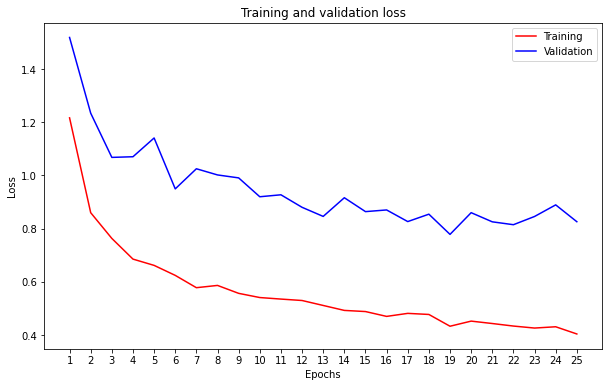

In [ ]:
# plot the training and validation losses
epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.title('Training and validation loss')
plt.legend()

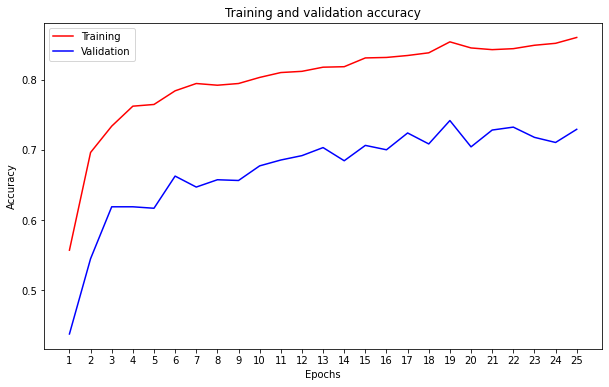

In [ ]:
# plot the training and validation accuracy
epochs = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs,accuracy,c="red",label="Training")
plt.plot(epochs,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.title('Training and validation accuracy')
plt.legend()

In [ ]:
# save model 
model.save('/content/GarBage_Classification_VGG16_finetune.h5')

# Test

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# load model
model = keras.models.load_model("/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/VGG16/GarBage_Classification_VGG16_finetune.h5")

In [ ]:
# accuracy 
score = model.evaluate(test_generator)
print("Accuracy of test data: {:.2f}%".format(score[1]*100))

61/61 [==============================] - 9s 149ms/step - loss: 1.3058 - accuracy: 0.6348
Accuracy of test data: 63.48%


## Plot Confunsion matrix

In [ ]:
Y_pred = model.predict(test_generator, 961 // val_batch_size+1)
y_train_pred = np.argmax(Y_pred, axis=1)

Classification Report
              precision    recall  f1-score   support

   cardboard       0.60      0.91      0.73       160
       glass       0.67      0.73      0.70       161
       metal       0.68      0.57      0.62       159
       paper       0.79      0.60      0.68       160
     plastic       0.55      0.53      0.54       160
       trash       0.56      0.47      0.51       161

    accuracy                           0.63       961
   macro avg       0.64      0.63      0.63       961
weighted avg       0.64      0.63      0.63       961

Confusion Matrix


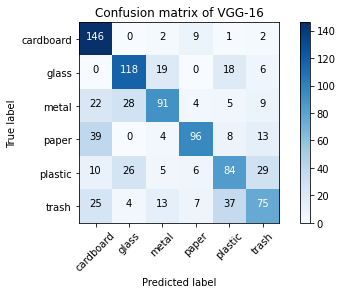

In [ ]:
labels = sorted(os.listdir('/content/Garbage classification/test'))

print('Classification Report')
print(classification_report(test_generator.classes, y_train_pred, target_names=labels, zero_division=1))

print('Confusion Matrix')
cnf_matrix = confusion_matrix(test_generator.classes, y_train_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix of VGG-16')